> This notebook provides an example on how to load an OpenEXR spectral image with Python using OpenImageIO wrapper.
>
> The layout is described in the JCGT paper  *An OpenEXR Layout for Spectral Images* - Alban Fichet, Romain Pacanowski, Alexander Wilkie https://jcgt.org/published/0010/03/01/
>
> Note this notebook does not provide *yet* an example on how to handle bispectral reflective images.

We propose a standardised layout to organise spectral data stored in OpenEXR images. We motivate why we chose the OpenEXR format as basis for our work, and we explain our choices with regard to data selection and organisation: our goal is to define a standard for the exchange of measured or simulated spectral and bi-spectral data. We also provide sample code to store spectral images in OpenEXR format.


First, we distinguish between *emissive* and *reflective* spectra. Both are used in distinct places within a rendering system, and do not share the same physical units.

An emissive spectrum $L_e(\lambda)$ describes radiant energy within a scene, such as for instance the radiance emitted by light sources. The image computed by a path tracer is a collection of emissive spectral values: it represents the spectral radiance reaching the sensor. The pixels in an environment map are a specialised case of light source, and also contain emissive spectral data. $L_e(\lambda)$ is expressed in $\mathrm{W}\cdot\mathrm{m}^{-2}\cdot\mathrm{sr}^{-1}\cdot\mathrm{nm}^{-1}$ in radiometric units\footnote{The corresponding photometric unit is $\mathrm{nits}$, which is used when working with such quantities in a tristimulus pipeline.}. 

On the other hand, a reflective spectrum describes the attenuation of energy after reflection, scattering or transmission/volume absorption events. For instance, an albedo texture image describes how a surface attenuates incoming radiant energy upon reflection. The albedo is unitless, and is normally used in the context of a BRDF model (in $\mathrm{sr}^{-1}$) that further describes the directional dependency of surface reflectance.

In [1]:
import OpenImageIO as oiio
from radiometry.cmf import CMF
import numpy as np
import os, re

In [2]:
import matplotlib.pyplot as plt

# Spectral channel extraction

Each channel is named according to the wavelength or frequency bracket it represents. Because the OpenEXR format reserves dots for separating different layers, we need to use a decimal comma notation for wavelength or frequency values. Wavelength/frequency values are always positive values, and an optional integer power of ten exponent also can be provided with E or e followed by an optional sign and an integer value.

This value is followed by an optional unit multiplier and by the used unit. These are either Hertz (`Hz`) or meters (`m`).

In this notebook, we are converting every value to nanometres with the following utility function:

In [3]:
def str_to_nm(value, multiplier, units):
    v = float(value.replace(',', '.'))

    # avoid rounding errors if the value is already in nanometres
    if multiplier == 'n' and units == 'm':
        return v

    unit_prefix = { 'Y':1e24, 'Z':1e21, 'E':1e18, 'P':1e15, 'T':1e12, 'G':1e9, 'M':1e6, 'k':1e3, 'h':1e2, 'd':1e1, '': 1, 'd':1e-1, 'c':1e-2, 'm':1e-3, 'u':1e-6, 'n':1e-9, 'p':1e-12}

    v *= unit_prefix[multiplier]

    if units == 'Hz':
        v = 299792458. / v * 1e9
    elif units == 'm':
        v *= 1e9
    else:
        raise ValueError

    return v

## Emissive images

Layers that store individual Stokes components of a polarized image are named `S0`, `S1`, `S2`, and `S3`. If there is no polarization information, only the `S0` layer is present.

In [4]:
def get_emissive_channels_idx(im):
    wl_nm = [[], [], [], []]
    idx = [[], [], [], []]

    regex = r'^S([0-3])\.*(\d*,?\d*([eE][-+]?\d+)?)(Y|Z|E|P|T|G|M|k|h|da|d|c|m|u|n|p|f|a|z|y)?(m|Hz)$'
    p = re.compile(regex)
    channels = im.spec().channelnames

    for c, i in zip(channels, range(len(channels))):
        m = p.match(c)

        if m:
            stokes_component = int(m.group(1))
            value = m.group(2)
            multiplier, units = m.group(4, 5)

            value = str_to_nm(value, multiplier, units)

            wl_nm[stokes_component].append(value)
            idx[stokes_component].append(i)

    return wl_nm, idx

## Reflective images

Layers that store reflective or attenuation values are named `T`.

In [5]:
def get_reflective_channels_idx(im):
    wl_nm = []
    idx = []

    regex = r'^T\.*(\d*,?\d*([eE][-+]?\d+)?)(Y|Z|E|P|T|G|M|k|h|da|d|c|m|u|n|p|f|a|z|y)?(m|Hz)$'

    p = re.compile(regex)
    channels = im.spec().channelnames

    for c, i in zip(channels, range(len(channels))):
        m = p.match(c)

        if m:
            value = m.group(1)
            multiplier, units = m.group(3, 4)

            value = str_to_nm(value, multiplier, units)

            wl_nm.append(value)
            idx.append(i)

    return wl_nm, idx

# Loading images

## Emissive images

The `idx_emissive` gives the indices of the spectral framebuffers for each Stokes component. The `wl_emissive` gives the wavelength corresponding to the framebuffers.

In [6]:
im_emissive = oiio.ImageInput.open(os.path.join('data', 'image', 'PolarisedRendering.exr'))
px_emissive = im_emissive.read_image()

# Extract emissive layers from the image
wl_emissive, idx_emissive = get_emissive_channels_idx(im_emissive)

Given the content of `idx_emissive`, we can determine if the image contains polarisation information.

In [7]:
is_polarised = idx_emissive[1] != None and idx_emissive[2] != None and idx_emissive[3] != None

print('Polarised image: {}'.format(is_polarised))

Polarised image: True


Now, we can display each framebuffer individually.

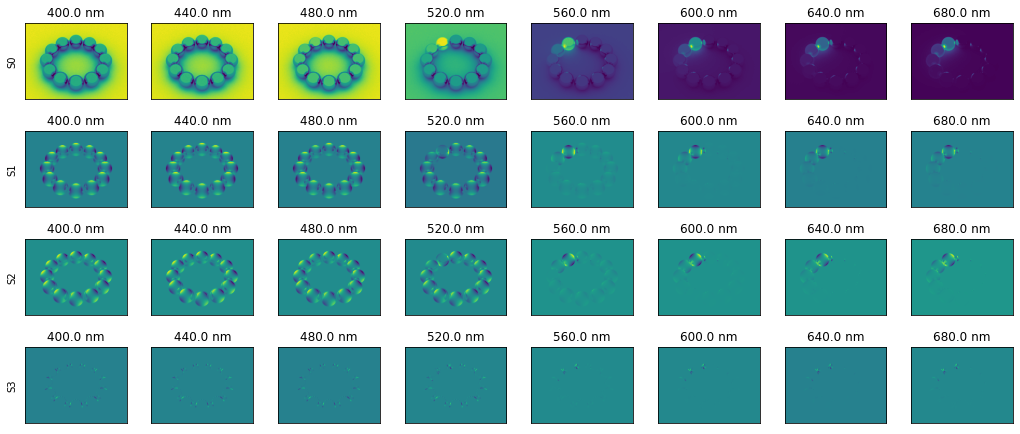

In [8]:
polarisation_components = 4 if is_polarised else 1

fig = plt.figure(figsize=(15, polarisation_components * 1.5))
subfigures = fig.subfigures(polarisation_components, 1)

for s_component in range(len(idx_emissive)):
    ax = subfigures[s_component].subplots(1, len(idx_emissive[s_component]))

    ax[0].set_ylabel('S{}'.format(s_component))

    for channel in range(len(idx_emissive[0])):
        ax[channel].imshow(px_emissive[:, :, idx_emissive[s_component][channel]])
        ax[channel].set_title('{} nm'.format(wl_emissive[s_component][channel]))
        ax[channel].set_xticks([])
        ax[channel].set_yticks([])

fig.tight_layout()
plt.show()

## Reflective image

For reflective image, we extract the list of framebuffers indices corresponding to the reflective spectrum `idx_reflective` along with their respective wavelength `wl_reflective`. 

In [9]:
im_reflective = oiio.ImageInput.open(os.path.join('data', 'image', 'Macbeth.exr'))
px_reflective = im_reflective.read_image()

wl_reflective, idx_reflective = get_reflective_channels_idx(im_reflective)

We can display each framebuffer corresponding to a specific wavelength.

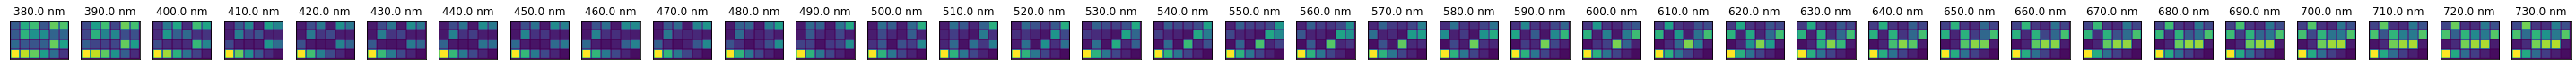

In [10]:
fig, ax = plt.subplots(1, len(idx_reflective), figsize=(40, 6))

for channel in range(len(idx_reflective)):
    ax[channel].imshow(px_reflective[:, :, idx_reflective[channel]])
    ax[channel].set_title('{} nm'.format(wl_reflective[channel]))
    ax[channel].set_xticks([])
    ax[channel].set_yticks([])

fig.tight_layout()
plt.show()

We can also easily extract the reflectance spectra at a given pixel.

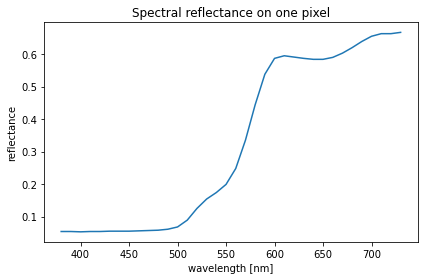

In [11]:
fig, ax = plt.subplots(1, 1)

ax.plot(wl_reflective, px_reflective[150, 15, idx_reflective])
ax.set_title('Spectral reflectance on one pixel')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('reflectance')

fig.tight_layout()
plt.show()

# Reflective Images

Layers that store reflective or attenuation values are named `T`.

# Colour Matchning Functions and sRGB conversion

In [12]:
# We use a coarser sampling for integration (each 10 nm) for performance reasons
cmf = CMF(os.path.join('data', 'cmf', 'ciexyz31.csv'), 5)

mat_sRGB = [[ 3.2404542, -0.9692660, 0.0556434],
            [-1.5371385, 1.8760108, -0.2040259],
            [-0.4985314, 0.0415560, 1.0572252]]


## Emissive images

For emissive images, we use the `S0` layer and convert the spectrum to RGB using the following pipeline:
- Emissive spectrum $L_e(\lambda)$ to CIE-XYZ $2^\circ$ 1931.
- XYZ to linear sRGB D65.

Steps (1) and (2) correspond to the following equation:

$$
\begin{equation}
  \begin{bmatrix}
    R \\ G \\ B
  \end{bmatrix} =
  \mathbf{M}_{\mathrm{XYZ} \rightarrow \mathrm{RGB}}
  \cdot
  \begin{bmatrix}
    \int_\Lambda L_e(\lambda) \cdot \bar{x}(\lambda) \mathrm{d}\lambda \\
    \int_\Lambda L_e(\lambda) \cdot \bar{y}(\lambda) \mathrm{d}\lambda \\
    \int_\Lambda L_e(\lambda) \cdot \bar{z}(\lambda) \mathrm{d}\lambda \\    
  \end{bmatrix}  
\end{equation}
$$

with:
- $\mathbf{M}_{\mathrm{XYZ} \rightarrow \mathrm{RGB}} =
  \begin{bmatrix}
    3.2404542 & -1.5371385 & -0.4985314 \\
   -0.9692660 &  1.8760108 &  0.0415560 \\
    0.0556434 & -0.2040259 &  1.0572252 \\
  \end{bmatrix}$
- $L_e(\lambda)$ the emissive spectrum,
- $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, $\bar{z}(\lambda)$ : the sensitivity curves for the CIE-XYZ $2^\circ$ 1931 colourspace.


In [13]:
img_emissive = px_emissive[:, :, idx_emissive[0]]
img_emissive_srgb = cmf.get_xyz_emissive_img(wl_emissive[0], img_emissive) @ mat_sRGB

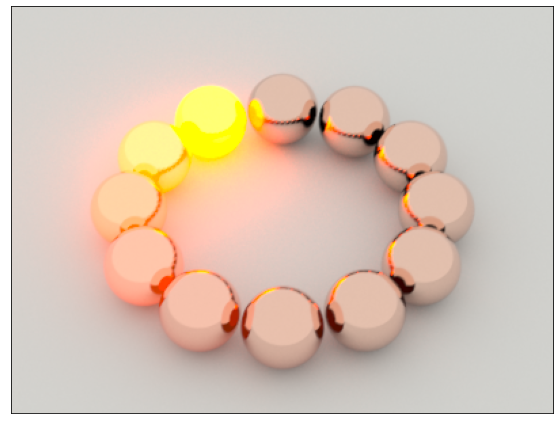

In [14]:
exposure = -7

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.imshow(np.clip(img_emissive_srgb * np.exp2(exposure), 0, 1) ** (1/2.2))

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
plt.show()


## Reflective images
For a reflective image, we use the `T` layer and convert the spectrum to RGB using the following pipeline:
- Multiplication of the spectrum $S(\lambda)$ with CIE D65 illuminant $L_\mathrm{D65}(\lambda)$.
- Spectrum projection to CIE-XYZ $2^\circ$ 1931 colourspace.
- Normalisation of components with CIE D65 Y component (CIE 1931 Y).
- XYZ to sRGB D65 linear.

The conversion is defined as follows:

$$
\begin{equation}
  \begin{bmatrix}
    R \\ G \\ B
  \end{bmatrix} = 
  \frac{1}{Y_{\mathrm{D65}}} 
  \cdot
  \mathbf{M}_{\mathrm{XYZ} \rightarrow \mathrm{RGB}}
  \cdot
  \begin{bmatrix}
    \int_\Lambda L_{\mathrm{D65}}(\lambda) \cdot S(\lambda) \cdot \bar{x}(\lambda) \mathrm{d}\lambda \\
    \int_\Lambda L_{\mathrm{D65}}(\lambda) \cdot S(\lambda) \cdot \bar{y}(\lambda) \mathrm{d}\lambda \\
    \int_\Lambda L_{\mathrm{D65}}(\lambda) \cdot S(\lambda) \cdot \bar{z}(\lambda) \mathrm{d}\lambda \\    
  \end{bmatrix}
\end{equation}
$$

with:
- $Y_{\mathrm{D65}} = \int_\Lambda L_{\mathrm{D65}}(\lambda) \cdot \bar{y}(\lambda) \mathrm{d}\lambda$,
- $S(\lambda)$ the reflective spectrum.

We first need to load an illumimant. We use a D65 illuminant.

In [15]:
# Load the illuminant spectrum
im_illu = oiio.ImageInput.open(os.path.join('data', 'image', 'D65.exr'))
px_illu = im_illu.read_image()

wl_illu, idx_illu = get_emissive_channels_idx(im_illu)

wl_illu = wl_illu[0]
value_illu = px_illu[0, 0, idx_illu[0]]

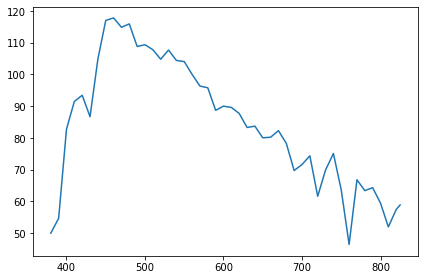

In [16]:
fig, ax = plt.subplots(1, 1)

ax.plot(wl_illu, value_illu)

fig.tight_layout()
plt.show()

Now, we can use the illuminant to perform the conversion on our spectral reflective image.

In [17]:
img_reflective = px_reflective[:, :, idx_reflective]
img_reflective_srgb = cmf.get_xyz_reflective_img(wl_illu, value_illu, wl_reflective, img_reflective) @ mat_sRGB

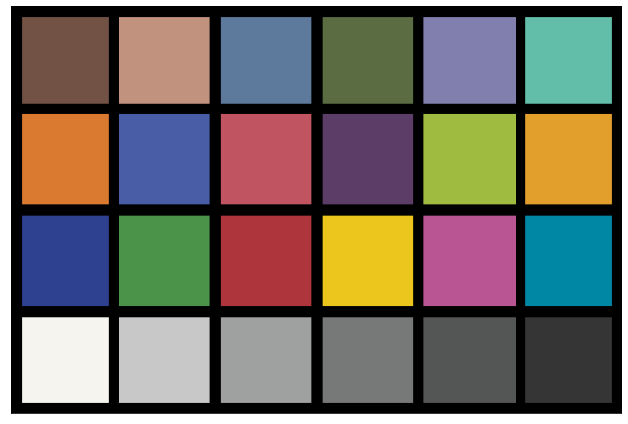

In [18]:
exposure = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.imshow(np.clip(img_reflective_srgb * np.exp2(exposure), 0, 1) ** (1/2.2))

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
plt.show()